# Part 03: Modeling:
In this part, I will do modeling with machine learning algorithm. The things I will do:
- Feature engineering
- Compare Linear Regression model with Decision Tree Regressor
- Hyperparameter tuning
- Evaluation
- Model Interpretation
- Save the model

## Library:

In [1]:
library(ggplot2)

In [2]:
library(caTools)

In [3]:
library(dplyr)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [4]:
library(fastDummies)

In [5]:
library(rpart)

In [6]:
library(randomForest)

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'randomForest'


The following object is masked from 'package:dplyr':

    combine


The following object is masked from 'package:ggplot2':

    margin




In [7]:
library(xgboost)


Attaching package: 'xgboost'


The following object is masked from 'package:dplyr':

    slice




In [8]:
library(mlr)

Loading required package: ParamHelpers

Warning message: 'mlr' is in 'maintenance-only' mode since July 2019.
Future development will only happen in 'mlr3'
(<https://mlr3.mlr-org.com>). Due to the focus on 'mlr3' there might be
uncaught bugs meanwhile in {mlr} - please consider switching.



## Data:

In [9]:
df <- read.csv("insuranceDataCleaned.csv")

In [10]:
df <- subset(df, select = (-c(sex)))

In [11]:
head(df)

,age,bmi,children,smoker,region,charges
,<int>,<dbl>,<int>,<chr>,<chr>,<dbl>
1,19,27.900,0,yes,southwest,16884.924
2,18,33.770,1,no,southeast,1725.552
3,28,33.000,3,no,southeast,4449.462
4,33,22.705,0,no,northwest,21984.471
5,32,28.880,0,no,northwest,3866.855
6,31,25.740,0,no,southeast,3756.622


## Feature Engineering:
According EDA in last part, I will do StandarScaler for Numerical variable (Age, Children, BMI, Charges) and One Hot Encoding for Qualitative variable (Smoker and Region). Sex variables were excluded to avoid bias

### One Hot Encoding:

In [12]:
df <- dummy_cols(df, remove_first_dummy = T)

In [13]:
df <- subset(df, select = -c(smoker, region))

In [14]:
head(df)

,age,bmi,children,charges,smoker_yes,region_northwest,region_southeast,region_southwest
,<int>,<dbl>,<int>,<dbl>,<int>,<int>,<int>,<int>
1,19,27.900,0,16884.924,1,0,0,1
2,18,33.770,1,1725.552,0,0,1,0
3,28,33.000,3,4449.462,0,0,1,0
4,33,22.705,0,21984.471,0,1,0,0
5,32,28.880,0,3866.855,0,1,0,0
6,31,25.740,0,3756.622,0,0,1,0


### Split Data

In [56]:
set.seed(101)

In [57]:
split <- sample.split(df$charges, SplitRatio = 0.8)

In [58]:
train <- subset(df, split == T)

In [59]:
test <- subset(df, split == F)

### Standard Scaler:

Train Scale

In [19]:
trainScaled <- scale(select(train, c(age, bmi, children)))

In [20]:
trainScaled <- cbind(trainScaled, subset(train, select = -c(age, bmi, children)))

In [21]:
head(trainScaled)

,age,bmi,children,charges,smoker_yes,region_northwest,region_southeast,region_southwest
,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>
1,-1.4350233,-0.4691320,-0.90179237,16884.924,1,0,0,1
2,-1.5058764,0.5031614,-0.05393305,1725.552,0,0,1,0
3,-0.7973456,0.3756203,1.64178558,4449.462,0,0,1,0
4,-0.4430803,-1.3296200,-0.90179237,21984.471,0,1,0,0
5,-0.5139333,-0.3068071,-0.90179237,3866.855,0,1,0,0
6,-0.5847864,-0.8269095,-0.90179237,3756.622,0,0,1,0


Test Scale:

In [22]:
testScaled <- scale(select(test, c(age, bmi, children)))

In [23]:
testScaled <- cbind(testScaled, subset(test, select = -c(age, bmi, children)))

In [24]:
head(testScaled)

,age,bmi,children,charges,smoker_yes,region_northwest,region_southeast,region_southwest
,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>
11,-1.0223073,-0.65647193,-0.9421388,2721.321,0,0,0,0
14,1.2257946,1.48509536,-0.9421388,11090.718,0,0,1,0
17,0.9357169,0.06158299,-0.1723425,10797.336,0,0,0,0
22,-0.6597102,0.31668144,-0.1723425,4149.736,0,0,0,1
25,-0.1520743,-0.37224186,0.5974539,6203.902,0,1,0,0
26,1.4433528,-0.42026965,1.3672503,14001.134,0,0,1,0


## Compare Linear Regression model with Decision Tree Regressor:
For the comparison, I will use Mean Absolute Error (MAE) becuase there is too many outliers in charges variables

### Linear Regression:

In [25]:
linear <- lm(charges ~ ., data = trainScaled)

In [26]:
predLinear <- predict(linear, testScaled)

### Decision Tree Regressor:
In decision tree, usually I don't use scaling data because decision tree model doesn't use distance to predict the answer

In [27]:
dt <- rpart(charges ~., method = "anova", data = train)

In [28]:
predTree <- predict(dt, test, method = "anova")

### Comparison:

In [29]:
true = test$charges

In [30]:
sprintf("MAE for Linear Regression: %.0f", mean(abs(true - predLinear)))

[1] "MAE for Linear Regression: 4336"

In [31]:
sprintf("MAE for Decision Tree: %.0f", mean(abs(true - predTree)))

[1] "MAE for Decision Tree: 3288"

The result is Decision Tree performed better than Linear Regression model and I think this makes sense because in EDA linear correlation between numerical variables and charges not too strong. 

## Hyperparameter Tuning:
From the above comparison model, I will tune the hyperparameter of Decision Tree model, such as max depth, min split, and min bucket. But, before I do that, I will test ensemble model like Random Forest and XGBoost to determine whether the decision tree model can be improved by using ensemble model or not

### Decision Tree:

In [32]:
dt <- rpart(charges ~., method = "anova", data = train)

In [33]:
predTree <- predict(dt, test, method = "anova")

In [34]:
sprintf("MAE for Decision Tree: %.0f", mean(abs(true - predTree)))

[1] "MAE for Decision Tree: 3288"

### Random Forest:

In [66]:
rfTree <- randomForest(charges ~ ., data = train)

In [67]:
predRfTree <- predict(rfTree, test)

In [68]:
sprintf("MAE for Random Forest Tree: %.0f", mean(abs(true - predRfTree)))

[1] "MAE for Random Forest Tree: 3241"

### XGBoost

In [38]:
xgbTree <- xgboost(as.matrix(select(train, -c(charges))), label = train$charges, nrounds = 2, objective = "reg:linear")

[22:07:56] WARNING: amalgamation/../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[1]	train-rmse:12995.233398 
[2]	train-rmse:9667.926758 


In [39]:
predXgbTree <- predict(xgbTree, as.matrix(select(test, -c(charges))))

In [40]:
sprintf("MAE for XGBoost Tree: %.0f", mean(abs(true - predXgbTree)))

[1] "MAE for XGBoost Tree: 6868"

### Random Forest Hyperparameter Tuning:
Random Forest model gives the best performance on my this data because of that I will tuning the hyperparameter of Random Forest

In [41]:
RF_tree <- makeRegrTask(data = train, target = "charges")

In [42]:
RF_learner <- makeLearner("regr.randomForest")

In [43]:
getParamSet(RF_learner)

                     Type  len   Def                 Constr Req Tunable Trafo
ntree             integer    -   500               1 to Inf   -    TRUE     -
se.ntree          integer    -   100               1 to Inf   Y    TRUE     -
se.method        discrete    -    sd bootstrap,jackknife,sd   Y    TRUE     -
se.boot           integer    -    50               1 to Inf   -    TRUE     -
mtry              integer    -     -               1 to Inf   -    TRUE     -
replace           logical    -  TRUE                      -   -    TRUE     -
strata            untyped    -     -                      -   -   FALSE     -
sampsize    integervector <NA>     -               1 to Inf   -    TRUE     -
nodesize          integer    -     5               1 to Inf   -    TRUE     -
maxnodes          integer    -     -               1 to Inf   -    TRUE     -
importance        logical    - FALSE                      -   -    TRUE     -
localImp          logical    - FALSE                      -   - 

In [44]:
param <- makeParamSet(makeIntegerParam("ntree", lower = 200, upper = 500), makeIntegerParam("mtry", lower = 3, upper = 5), makeIntegerParam("nodesize", lower = 1,upper = 3), makeIntegerParam("maxnodes", lower = 5, upper = 10))

In [45]:
randSearch <- makeTuneControlRandom(maxit = 100)

In [46]:
Kfold <- makeResampleDesc(method = "RepCV", fold = 10, reps = 5)

In [48]:
Turning_para <- tuneParams(RF_learner, RF_tree, resampling = Kfold, par.set = param, control = randSearch)

[Tune] Started tuning learner regr.randomForest for parameter set:

            Type len Def     Constr Req Tunable Trafo
ntree    integer   -   - 200 to 500   -    TRUE     -
mtry     integer   -   -     3 to 5   -    TRUE     -
nodesize integer   -   -     1 to 3   -    TRUE     -
maxnodes integer   -   -    5 to 10   -    TRUE     -

With control class: TuneControlRandom

Imputation value: Inf

[Tune-x] 1: ntree=424; mtry=5; nodesize=1; maxnodes=5

[Tune-y] 1: mse.test.mean=28481491.4596981; time: 0.2 min

[Tune-x] 2: ntree=242; mtry=4; nodesize=2; maxnodes=10

[Tune-y] 2: mse.test.mean=24716668.7011322; time: 0.1 min

[Tune-x] 3: ntree=435; mtry=4; nodesize=2; maxnodes=10

[Tune-y] 3: mse.test.mean=24600115.4808140; time: 0.2 min

[Tune-x] 4: ntree=287; mtry=3; nodesize=2; maxnodes=5

[Tune-y] 4: mse.test.mean=43711641.8278469; time: 0.1 min

[Tune-x] 5: ntree=314; mtry=3; nodesize=3; maxnodes=8

[Tune-y] 5: mse.test.mean=31644953.1470172; time: 0.1 min

[Tune-x] 6: ntree=243; mtry

In [49]:
Turning_para

Tune result:
Op. pars: ntree=496; mtry=5; nodesize=1; maxnodes=10
mse.test.mean=22331912.1105738

From here, the best hyperparameter is:
- ntree = 496
- mtry = 5
- nodesize = 1
- maxnodes = 10

## Evaluation:
In this part, I will compare hyperparmeter tuning result with default Random Forest to check if there is a performance increase or not. I will use MAE to check that

### Random Forest Default:

In [73]:
rfTree <- randomForest(charges ~ ., data = train)

In [74]:
predRfTree <- predict(rfTree, test)

In [75]:
sprintf("MAE for Random Forest Tree: %.0f", mean(abs(true - predRfTree)))

[1] "MAE for Random Forest Tree: 3235"

### Random Forest After Tuning

In [104]:
rfTreeTuning <- randomForest(charges ~ ., data = train, ntree = 496, mtry = 5, nodesize = 1, maxnodes = 10, importance = TRUE)

In [105]:
predRfTreeTuning <- predict(rfTreeTuning, test)

In [106]:
sprintf("MAE for Random Forest Tree: %.0f", mean(abs(true - predRfTreeTuning)))

[1] "MAE for Random Forest Tree: 2667"

There is a significant increase in performance after the model is tuned so that in the future the model I will use is the model that has been tuned.

## Model Interpretation:
Random Forest is one of the models that is not easy to interpret. One way that can be done to see how this model determine the results is to look at feature importance. Through feature importance, I can answer my curiosity about "What features are the most influential in determining the insurance fee of each customer?" in Part 01

In [121]:
importance <- importance(rfTreeTuning)

In [127]:
importance

,%IncMSE,IncNodePurity
age,98.3117846,13357136656
bmi,57.4165909,17544893366
children,17.1206991,722821265
smoker_yes,152.1224945,95934902270
region_northwest,0.2025584,29060741
region_southeast,-0.9306594,48029142
region_southwest,1.1597559,34832693


In [131]:
varImportance <- data.frame(Variables = row.names(importance), Importance = round(importance[,'IncNodePurity'], 2))

In [133]:
rankImportance <- varImportance %>% mutate(Rank = paste0('#', dense_rank(desc(Importance))))

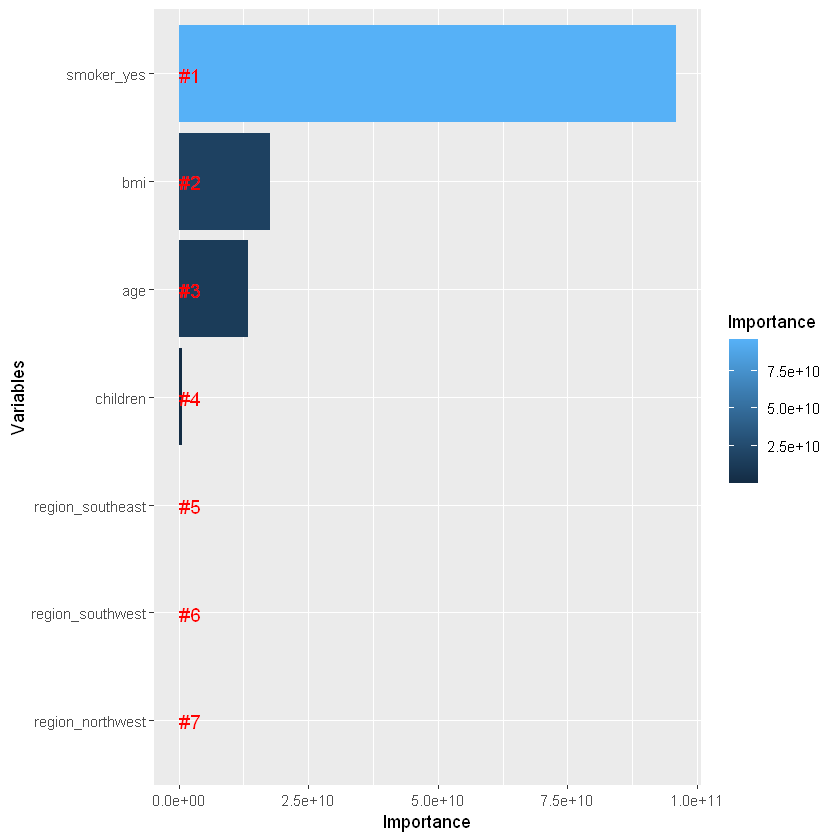

In [135]:
ggplot(rankImportance, aes(x = reorder(Variables, Importance), y = Importance, fill = Importance)) + geom_bar(stat = 'identity') + geom_text(aes(x=Variables, y = 0.5, label = Rank), hjust = 0, vjust = 0.55, size = 4, colour = "red") + labs(x = 'Variables') + coord_flip()

### Interpretation:
- %IncMSE: This shows how much our model accuracy will be decrease if I leave out that variable. In this case, if I remove smoker_yes variables, the accuracy of the model will decrease a lot so this variable is the most important variable and this is in accordance with the EDA have I done that customers who smoke will have higher charges than those who don't. Beside that, there is age and bmi variable which is quite important but not as important as smoker
- IncNodePurity: This is measure a variable importance based on the Gini Impurity index used for the calculating the splits in trees and the result still same, smoker is the most influential variable in determining charges for customers 

## Save The Model:
I will save the model so that it can be deployed to predict customers charges for medical insurance. I save the model in .RData form 

In [139]:
save(rfTreeTuning, file = "Deployment/API/model.RData")

## Thank You!
For now, this project stops here first. However, in the future I will continue the project to carry out deployment 